# Overview 

In this notebook, I will continue to build on the insights from notebook **3.1. Modeling - A Simple Model and Grouping Misclassifications** to discuss a more data-driven approach to the problem of understanding a neural network model. More specifically, I will look at the viausalized output of the hidden layers of the neural network to see what features are being learnt at these layers. 

Ideally, I would use the model which I built in the previous notebook to stay consistent with disecting the one and the same model, but the original model was too simple to lead to any esaily  interpretable results that made sense. Therefore, here I will use a more complex neural network and I will visualize the output of each layer to show how this technique can be used to help undertsand what the model is doing at each layer.

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


# 1. Data Import and Preprocessing 

Here I will repeat the same procedure as in notebook **3.1. Modeling - A Simple Model and Grouping Misclassifications** for the data import and preprocessing parts. 

In [55]:
###Extract from file
with open("./data/processed_data/X.pkl","rb") as f:
    X = pickle.load(f)
    
###Extract from file
with open("./data/processed_data/y.pkl","rb") as f:
    y = pickle.load(f)


# create an index corresponding to individual images in the data
indeces = list(range(1,25001))
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, y,indeces, random_state=42, stratify = y)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Reshape each image to be 28 x 28 x 1.
X_train = X_train.reshape(X_train.shape[0], 66, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 66, 100, 1)

# Dummy the target variable 
y_train = np_utils.to_categorical(y_train, 5)
y_test = np_utils.to_categorical(y_test, 5)

print(X_train.shape)
print(y_train.shape)
print(len(indices_train))
print(X_test.shape)
print(y_test.shape)
print(len(indices_test))

(18750, 66, 100, 1)
(18750, 5)
18750
(6250, 66, 100, 1)
(6250, 5)
6250


# 2. Modeling - A More Complex Convolutional Neural Network Model 

The following neural is more complex than the original one I built. It differs from the original one by the following characteristis:  

1. Stochastic gradient descent as optimizer
2. Batch normalization which normalizes the input layer by adjusting and scaling the acttivations
3. dropout regularization to combat overfitting. 
4. An additional convolution layer 
5. An additional pooling layer 
6. Much smaller number of epochs needed to achieve significantly higher accuracy 

**The code for this model was adapted from [here](https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras) and was modified to fit my data**

In [5]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

inputShape=(66,100,1)
input = Input(inputShape)

x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same')(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)


x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)

x = Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool3')(x)


x = Flatten()(x)
x = Dense(3000,activation = 'relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(3000,activation = 'relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(5,activation = 'softmax',name='fc2')(x)

cnn_model = Model(inputs = input,outputs = x,name='Predict')

In [7]:
# define the optimizer
momentum = 0.5
sgd = SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False) 

# compile the model
cnn_model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [21]:
history=cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=5,verbose=1)

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 539s 29ms/step - loss: 0.0102 - acc: 0.9977 - val_loss: 0.2256 - val_acc: 0.9422
Epoch 2/5
18750/18750 [==============================] - 536s 29ms/step - loss: 0.0069 - acc: 0.9988 - val_loss: 0.2149 - val_acc: 0.9466
Epoch 3/5
18750/18750 [==============================] - 533s 28ms/step - loss: 0.0059 - acc: 0.9986 - val_loss: 0.2099 - val_acc: 0.9523
Epoch 4/5
18750/18750 [==============================] - 530s 28ms/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.2149 - val_acc: 0.9539
Epoch 5/5
18750/18750 [==============================] - 527s 28ms/step - loss: 0.0040 - acc: 0.9995 - val_loss: 0.1991 - val_acc: 0.9566


In [22]:
# save model to JSON
model_json = cnn_model.to_json()
with open("./model/cnn_model_2_architecture.json", "w") as json_file:
    json_file.write(model_json)
# save weights to HDF5
cnn_model.save_weights("./model/cnn_model_2_weights.h5")
print("Saved model to disk")

Saved model to disk


Let's view the architecture of this CNN 

In [23]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 66, 100, 1)        0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 66, 100, 64)       640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 66, 100, 64)       256       
_________________________________________________________________
activation_7 (Activation)    (None, 66, 100, 64)       0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 33, 50, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 33, 50, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 33, 50, 64)        256       
__________

# 3. Model Evaluation 

I will proceed with evaluating this model using the same metrics as before. 

In [24]:
# Evaluate model on test data.
score = cnn_model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = cnn_model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

6250/6250 [==============================] - 35s 6ms/step
loss: 0.19907038598168175
acc: 0.95664


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


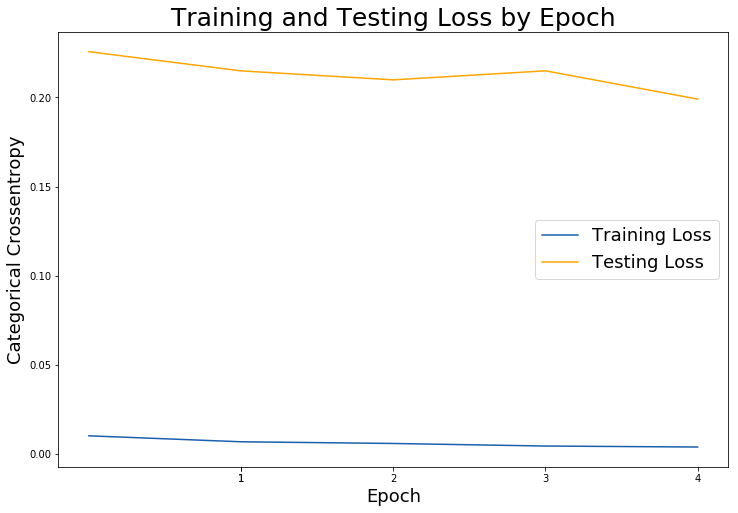

In [32]:
# plot the loss for training and testing sets over epochs 
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(list(np.linspace(1,4.1,5.1).astype(int)))

plt.legend(fontsize = 18);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


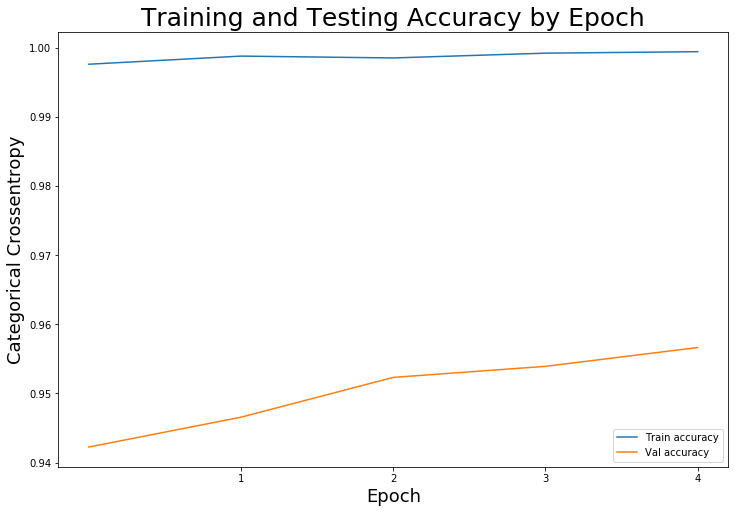

In [31]:
# Plot the accuracy for training and testing sets over ecpochs 
plt.figure(figsize=(12, 8))

plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Val accuracy')
plt.legend();

plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(list(np.linspace(1,4,4.1).astype(int)));

In [27]:
from sklearn.metrics import confusion_matrix
Y_prediction = cnn_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

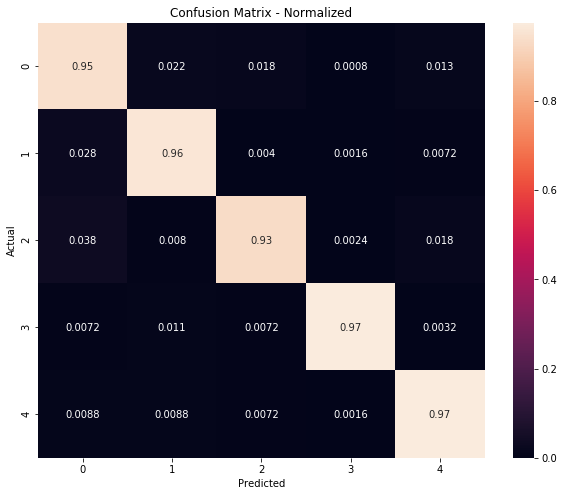

In [39]:
# compute the normalized confusion matrix
import seaborn as sns
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes).astype('float') / confusion_matrix(Y_true, Y_pred_classes).sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True);

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Normalized');

### Comment on Mode Performance

This model results in a higher accuracy score as compared to its simpler version discussed in notebook **3.1.Modeling - A Simple Model and Grouping Misclassifications** and achieves this score with very few epochs. Still computationally very expensive as it takes about an hour to run 4 epochs. With a smaller number of incorrectly classified images (only 271 misclassified images), this would be a better model to visually inspect misclassified images. 
<br/>
<br/>
<br/>
Now let's look into how the output of hidden layers can be visualized. 

# 4. Visualizing the Output from Hidden Layers

**The code for visualizing the output of hidden layers was adapted from [here](https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras) and was modified to fit my data**

In [72]:
# the following function will take the activation outputs of a given layer in our model and will visualize them as images

from keras.models import Model
layer_outputs = [layer.output for layer in cnn_model.layers][1:]
activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[2473].reshape(1,66,100,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

 So let's look at a doodle image of a cat that was misclassified as a tree (image 2473: y_test = 0 for cat and y_pred = 4 for tree). The below code alligns the misclassified doodles with their corresponding images via the **index** column created during the train_test_split

In [56]:
predictions = pd.DataFrame({'index':indices_test, 
                            'y_test':list(Y_true), 
                            'y_pred':list(Y_pred_classes)})

In [57]:
mask = predictions['y_test']!=predictions['y_pred']
misclass = predictions[mask]
misclass.shape 

(271, 3)

In [81]:
misclass.head()

,index,y_test,y_pred
4,13220,2,0
6,16919,3,2
18,11005,2,0
27,18604,3,1
41,2473,0,4


Here is the misclassified doodle image in its original form: 

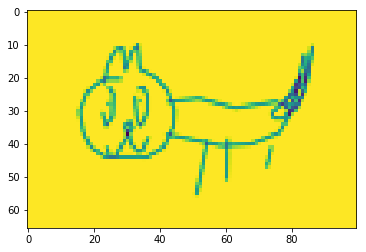

In [79]:
plt.imshow(X_train[2473][:,:,0]);

### The output of doodle image as it gets fed through the layers of the CNN

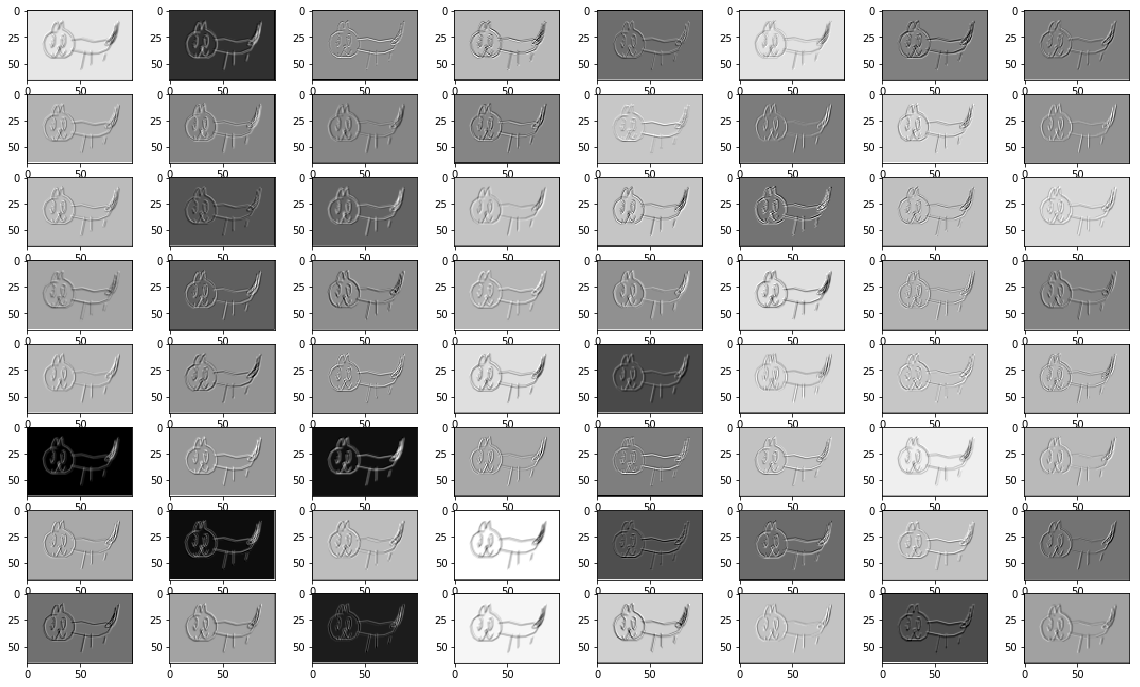

In [73]:
# displaying after 2 layers  (layer 1 is input layer)
display_activation(activations, 8, 8, 1)

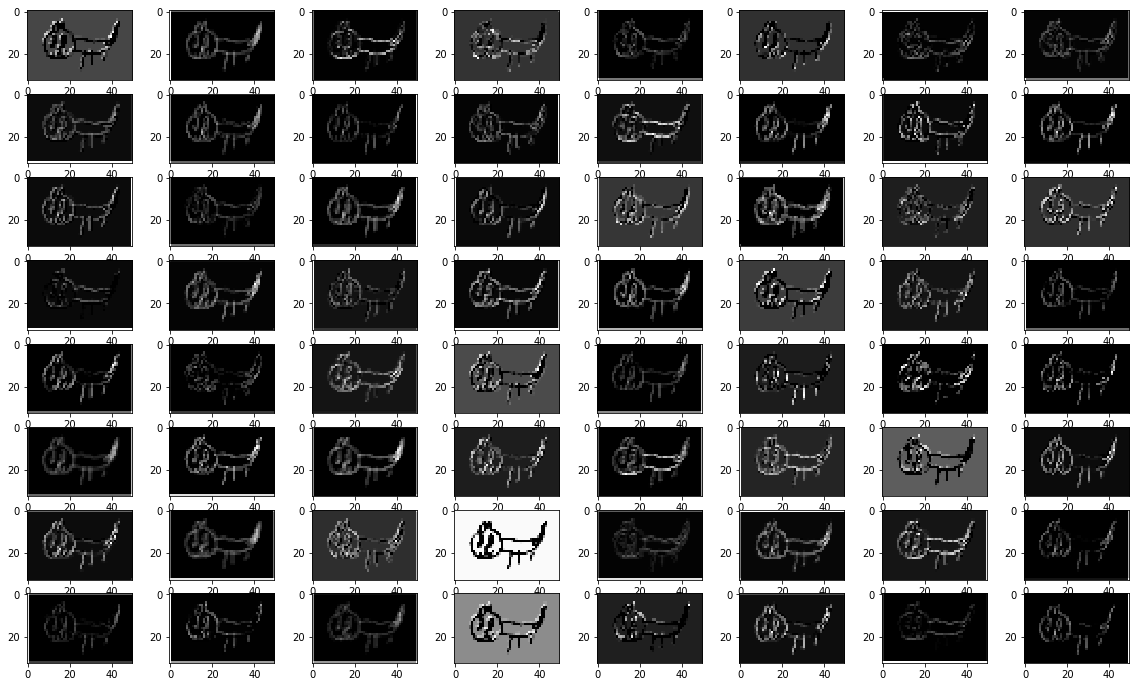

In [74]:
# displaying after 4 layers 
display_activation(activations, 8, 8, 3)

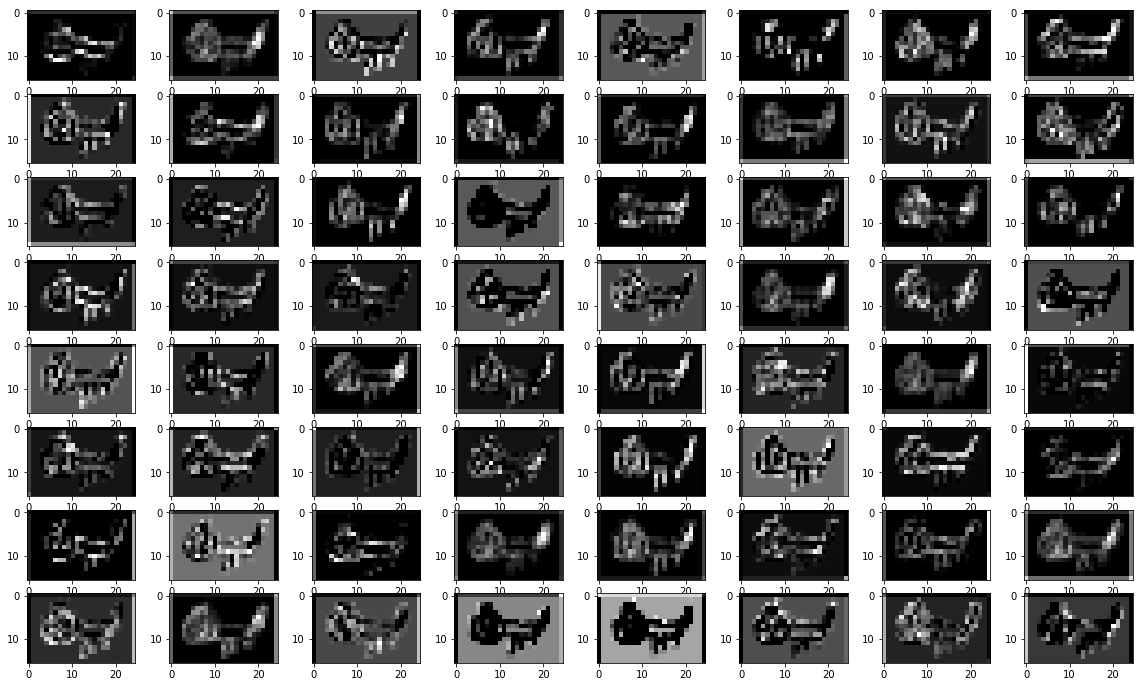

In [80]:
# displaying after 4 layers 
display_activation(activations, 8, 8, 7)

### Comment on visualized hiddel layer outputs

As the image gets fed through each layer, it becomes more and more blurred and abstract looking with the output of the final layer appearing to be the least clear to a human's eye. However each sub-image produced by every layer seems to be focusing on a distinct set of features of the image, making different portionts or segments of the image more apparent distincly from the other sub-images within that layer. 

While this is not a conclusion, but only a rough guess based on my human judgement, the transformed image of the cat doodle after the last layers has lost so much clarity in it that it just looks like an undefined blob of grey-scale pixels which may remotely look like the shape of a typical tree doodle that I showed in notebook 3.1. This may or may not be a reason why the model is misclassifying this cat image as a tree but the level of understanding we have acquired so far is certainly not enough to come to such conclusions. In order to understand this better we would need to look how the neural network hidden layers are representing actual typical tree doodles (true positives at that) and look at how the neural network hidden layers are also representing cat doodles (true positives at that). 

### So what do we learn from visualizing hidden layers?

While a great deal of subjective judgement is still neecssary to interpret what the hidden layers our outputting, the fact that we have the ability to look inside the neural network is already a great advantage in coming a step closer to undersatnding how the model works and where and why it may fail to correctly predict a category of an image. The insights learned from looking at visualizations of hidden layers combined with insights gained from grouping the misclassifications into sets of images that share a distinct characteristic are approaches that can help us undersatnd why the model is failing at correctly predicting the classes of particular images. 